## 0. Импорт необходимых библиотек

In [44]:
#Классический набор
import numpy as np
import pandas as pd

#Маламальская визуализация
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm

#Мода для модников
from scipy.stats import mode

#Выбросы
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Нормализация
from sklearn.preprocessing import StandardScaler

# Игнорируем всё
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 0.1 Импортируем датасет и немного манипулируем

Задаю na_values, чтобы питон сразу понял. Как именно запроганы пропуски в данных

In [2]:
df = pd.read_csv('bank.csv', sep=';',na_values='unknown')
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,NaN,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(41188, 21)

In [4]:
df.drop_duplicates(inplace=True, ignore_index=True)

In [5]:
df.shape

(41176, 21)

## 1. Разговор о пропусках

Посчитаю количество пропусков в существующих признаках:

In [6]:
missing = df.isnull().sum()[df.isnull().sum() > 0].sort_values()
missing

marital        80
job           330
housing       990
loan          990
education    1730
default      8596
dtype: int64

Для себя запринтовала датасет со строчками, где есть хоть какие-то пропуски:

In [7]:
df[df.isnull().any(1)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,NaN,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
10,41,blue-collar,married,NaN,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
15,54,retired,married,basic.9y,NaN,yes,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41106,34,technician,married,NaN,no,yes,no,cellular,nov,tue,...,2,999,2,failure,-1.1,94.767,-50.8,1.046,4963.6,no
41108,60,admin.,married,NaN,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.046,4963.6,no
41110,34,technician,married,NaN,no,no,no,cellular,nov,tue,...,3,999,0,nonexistent,-1.1,94.767,-50.8,1.046,4963.6,yes
41123,54,technician,married,NaN,no,yes,no,cellular,nov,thu,...,1,999,1,failure,-1.1,94.767,-50.8,1.041,4963.6,no


Немного визуализации:

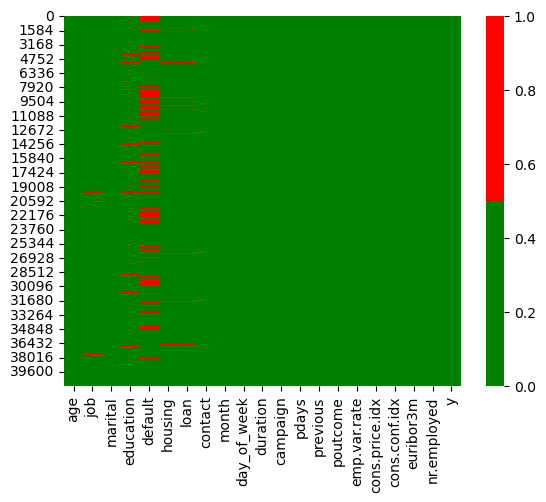

In [8]:
cols = df.columns 
# красный - пропущенные числовые данные, зеленый - не пропущенные
colours = ['green', 'red'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours));

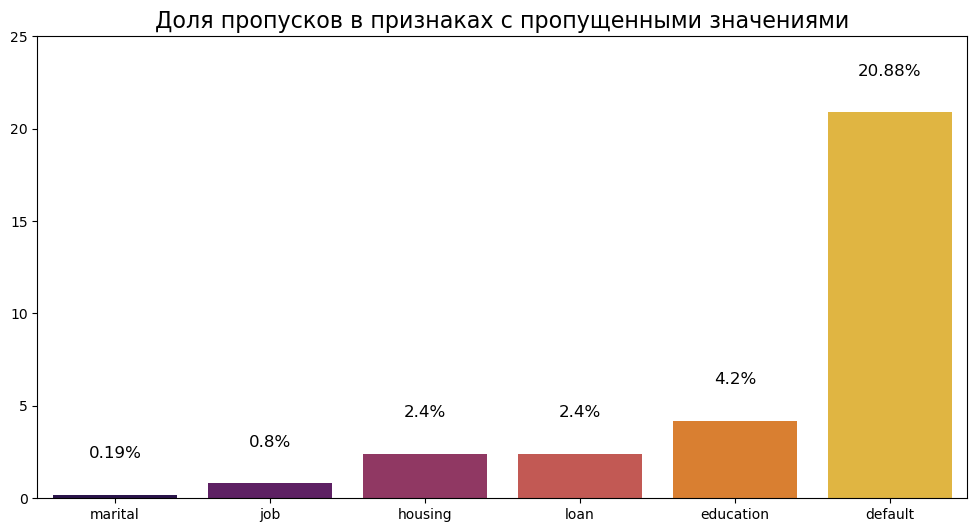

In [9]:
missing_per = (missing/len(df)*100).sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_per.index, y=missing_per, palette='inferno')
for i in range(6):
    plt.text(i, missing_per[i] + 2, f'{round(missing_per[i], 2)}%', fontsize=12, ha='center')
plt.ylim([0, 25])
plt.title("Доля пропусков в признаках с пропущенными значениями", fontsize=16);

Обо всём по порядку. Начну с Работы и Образования.

In [10]:
agg_func_stats = {'job': [mode, pd.Series.mode]}
df.groupby(['education']).agg(agg_func_stats)

job             
                                        mode         mode
education                                                
basic.4y             ([blue-collar], [2318])  blue-collar
basic.6y             ([blue-collar], [1425])  blue-collar
basic.9y             ([blue-collar], [3623])  blue-collar
high.school               ([admin.], [3329])       admin.
illiterate              ([blue-collar], [8])  blue-collar
professional.course   ([technician], [3317])   technician
university.degree         ([admin.], [5750])       admin.

In [11]:
df.fillna(value={'job' : 0}, inplace=True)
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41172,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41173,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41174,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [12]:
for i in range(41175):
    if df.job[i] == 0:
        if df.education[i]== 'basic.4y' or df.education[i]== 'basic.6y' or df.education[i]== 'basic.9y' or df.education[i]== 'illiterate':
            df.loc[i:i, ('job')] = 'blue-collar'
            i=i+1
        elif df.education[i]== 'high.school' or df.education[i]== 'university.degree':
            df.loc[i:i, ('job')] = 'admin.'
            i=i+1
        elif df.education[i]== 'professional.course':
            df.loc[i:i, ('job')] = 'technician'
            i=i+1
        else:
            i=i+1

In [13]:
df.job.value_counts()

admin.           10501
blue-collar       9358
technician        6751
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
0                  131
Name: job, dtype: int64

Краткий итог: Осталось 131 пропусков (который сейчас = 0), то есть 199 я раскидала по моде следуя образованию. Пойдёт.

Теперь поговорим об образовании. Поступаю аналогично, хоть всё же рассуждения о том, что от образования зависит работа... спорно, но всё же логично. Мода тоже так себе мера, но всё равно не так грубо, как те способы, которые мы обсуждали.

In [14]:
agg_func_stats = {'education': [mode, pd.Series.mode]}
df.groupby(['job']).agg(agg_func_stats)

education                     
                                          mode                 mode
job                                                                
0                                   ([0], [0])                   []
admin.           ([university.degree], [5795])    university.degree
blue-collar               ([basic.9y], [3654])             basic.9y
entrepreneur      ([university.degree], [610])    university.degree
housemaid                  ([basic.4y], [474])             basic.4y
management       ([university.degree], [2063])    university.degree
retired                    ([basic.4y], [597])             basic.4y
self-employed     ([university.degree], [765])    university.degree
services               ([high.school], [2680])          high.school
student                 ([high.school], [357])          high.school
technician     ([professional.course], [3329])  professional.course
unemployed        ([university.degree], [262])    university.degree

In [15]:
df.fillna(value={'education' : 0}, inplace=True)

In [16]:
for i in range(41175):
    if df.education[i] == 0:
        if df.job[i]== 'housemaid' or df.job[i]== 'retired':
            df.loc[i:i, ('education')] = 'blue-collar'
            i=i+1
        elif df.job[i]== 'blue-collar':
            df.loc[i:i, ('education')] = 'basic.9y'
            i=i+1
        elif df.job[i]== 'services' or df.job[i]== 'student':
            df.loc[i:i, ('education')] = 'high.school'
            i=i+1
        elif df.job[i]== 'technician':
            df.loc[i:i, ('education')] = 'professional.course'
            i=i+1    
        elif df.job[i]== 'unemployed' or df.job[i]== 'self-employed' or df.job[i]== 'management' or df.job[i]== 'entrepreneur' or df.job[i]== 'admin.':
            df.loc[i:i, ('education')] = 'university.degree'
            i=i+1              
        else:
            i=i+1

In [17]:
df.education.value_counts()

university.degree      12641
high.school             9829
basic.9y                6499
professional.course     5452
basic.4y                4176
basic.6y                2291
blue-collar              139
0                        131
illiterate                18
Name: education, dtype: int64

Перекрёстный обмен завершён)


Про остальные 0 подумаю чуть позже. А пока присутим к следующим пропускам:

Считаю, что пропуски в семейном положении нужно заполнить чисто неизвестной категорией, т.е. пусть то, что было неизвестно, так и останется категорией "unknown".

In [18]:
df['marital'].fillna('unknown', inplace=True)

Ну что же у нас там осталось?

In [19]:
missing = df.isnull().sum()[df.isnull().sum() > 0].sort_values()
missing

housing     990
loan        990
default    8596
dtype: int64

Проверю одну свою теорию, которую выдвинула в прошлом:

*Причём что интересно. Количество пропусков по housing и loan совпадают. Можно предположить, что данные пропуски - ошибка работников колл-центра (сотрудники могли забыть задать эти вопросы).*

In [20]:
df[df.loan.isnull()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
29,55,admin.,married,university.degree,NaN,NaN,NaN,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
81,51,blue-collar,married,basic.4y,NaN,NaN,NaN,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
261,27,blue-collar,single,basic.6y,no,NaN,NaN,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
385,59,management,married,basic.4y,NaN,NaN,NaN,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
401,48,services,married,high.school,NaN,NaN,NaN,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40978,31,admin.,single,university.degree,no,NaN,NaN,cellular,oct,tue,...,1,3,1,success,-1.1,94.601,-49.5,1.008,4963.6,yes
41002,31,technician,single,professional.course,no,NaN,NaN,cellular,oct,thu,...,2,999,0,nonexistent,-1.1,94.601,-49.5,1.025,4963.6,yes
41003,34,admin.,divorced,university.degree,no,NaN,NaN,cellular,oct,thu,...,2,999,1,failure,-1.1,94.601,-49.5,1.025,4963.6,no
41017,46,management,married,university.degree,no,NaN,NaN,cellular,oct,mon,...,2,12,2,failure,-1.1,94.601,-49.5,1.032,4963.6,no


На первый взгляд так и есть. Сравним два датасета:

In [21]:
df[df.loan.isnull()].equals(df[df.housing.isnull()])

True

Ну что ж... Так и есть. Тогда...

Сраные кредиты. Тут я соглашусь сама с собой из прошлого. А именно:

Работаем с оставшимися категориальными данными : default, housing и loan. Как было получено из разведочного анализа данных, в этих признаках присутсвуют данные, содержащие ответ на вопрос: "Есть ли такой-то кредит", то есть ответы "yes", "no" и пропуски. Так как исследователь тут я, и решение по заполнению пропусков принимаю я, поэтому все пропуски приравниваются к "no". Предполагается, что если бы у клиента был тот или иной кредит, то об этом бы знали сами сотрудники банка, а клиент уж точно был бы осведомлён. В случае если клиент сам скрыл эту информацию (не захотел делиться столь ценными данными), то значит флаг ему в руки, никаких кредитов у него нет.

Ожидаемо, что в итоге данные преобразуются в набор нулей и единиц, так как по сути default, housing и loan - фиктивные переменные. Поэтому надо использовать OneHotEncoder, где 0 - "no", а 1 - "yes".

## 2. Вопрос особенности кодировки числовых признаков

Ну как кодировать пропуски я разобралась. А теперь разберёмся с кодировкой одного особенного признака.

Дурацкий pdays. Ничего умнее своего старого решения я придумать не смогла. Только что добавлю новый признак, в котором всё кроме 999 = 1, а 999=0. В совокупности они должны дать что-то стоящее... Наверное

In [22]:
df["pdays_fict"]=np.where(df.pdays == 999, 0, 1)
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_fict
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,0
41172,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41173,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41174,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,0


Дебильные 999 заменим не на такое большое число, а на 40.

In [23]:
df.loc[(df.pdays == 999), 'pdays'] = 40
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_fict
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,40,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,40,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,40,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,40,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,40,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,40,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,0
41172,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,40,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41173,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,40,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41174,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,40,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,0


## 3. Обработка выбросов

In [24]:
numerical_discr = [f for f in df.columns if df.dtypes[f] == 'int64']
numerical_cont = [f for f in df.columns if df.dtypes[f] == 'float64']
numerical = numerical_cont + numerical_discr

In [25]:
X = StandardScaler().fit_transform(df[numerical].values)

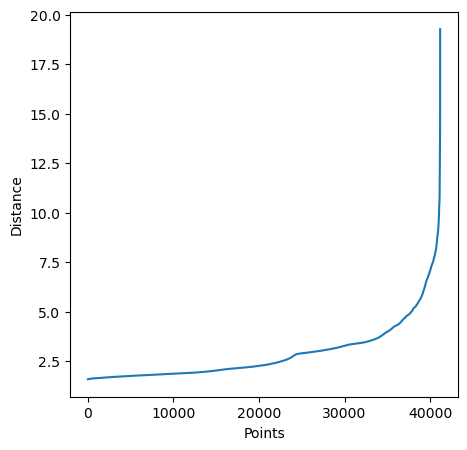

In [26]:
nearest_neighbors = NearestNeighbors(n_neighbors=10001)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

distances = np.sort(distances[:, 10000], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance");

plt.savefig("Distance_curve.png", dpi=300)

4.012638547272138


<Figure size 500x500 with 0 Axes>

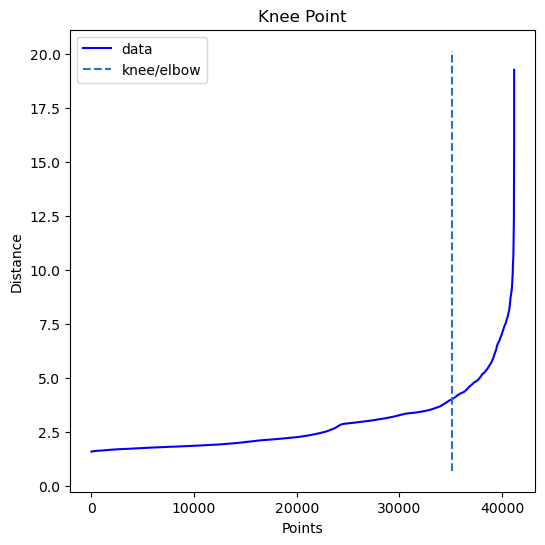

In [27]:
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("knee.png", dpi=300)
print(distances[knee.knee])

In [30]:
db = DBSCAN(eps=distances[knee.knee], min_samples=10000).fit(X)
labels = db.labels_

In [31]:
pd.Series(labels).value_counts()

 0    39431
-1     1745
dtype: int64

In [32]:
df['Outliers'] = labels
df[df['Outliers'] == -1]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_fict,Outliers
1688,26,admin.,married,high.school,no,yes,yes,telephone,may,fri,...,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,0,-1
2312,39,self-employed,married,basic.4y,NaN,yes,no,telephone,may,tue,...,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,0,-1
2329,38,blue-collar,single,basic.9y,no,yes,no,telephone,may,tue,...,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,yes,0,-1
3437,35,unemployed,married,university.degree,no,no,no,telephone,may,thu,...,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no,0,-1
3773,35,student,single,high.school,no,no,yes,telephone,may,fri,...,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,yes,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41152,54,admin.,married,professional.course,no,no,no,cellular,nov,tue,...,1,success,-1.1,94.767,-50.8,1.035,4963.6,yes,1,-1
41158,40,management,divorced,university.degree,no,yes,no,cellular,nov,wed,...,4,failure,-1.1,94.767,-50.8,1.030,4963.6,no,0,-1
41162,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,...,6,success,-1.1,94.767,-50.8,1.031,4963.6,yes,1,-1
41166,62,retired,married,university.degree,no,no,no,cellular,nov,thu,...,3,success,-1.1,94.767,-50.8,1.031,4963.6,yes,1,-1


In [33]:
df1 = df[df['Outliers']==0]
df1.index = pd.RangeIndex(0, len(df1))
df1

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_fict,Outliers
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39426,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,0,0
39427,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0,0
39428,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0,0
39429,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,0,0


In [36]:
df1.to_csv('bank_wo.csv')

In [37]:
def cat_num_plot(feature):
    plt.suptitle(f'Рисуночек {feature} по результирующему признаку', fontsize=10)
    sns.boxplot(data=df1, x=feature, y='y', palette="viridis", notch=True, showcaps=False,
                   flierprops={"marker": "x"}, medianprops={"color": "yellow"})
    plt.show()

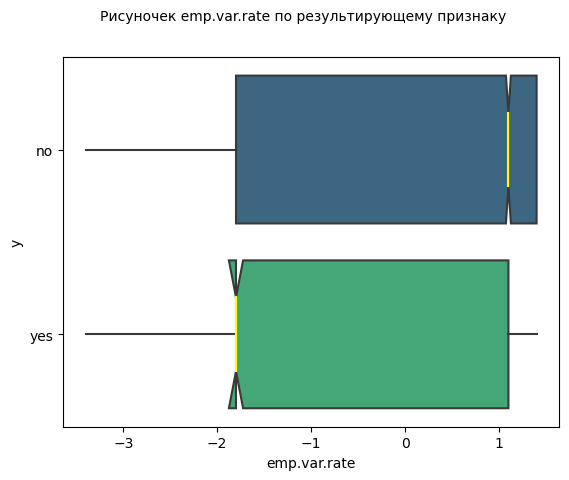

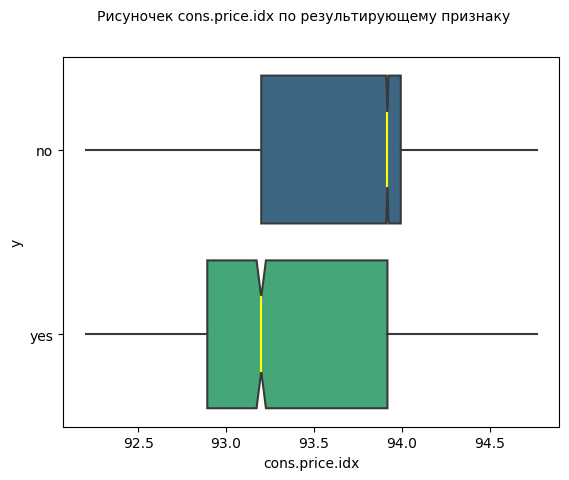

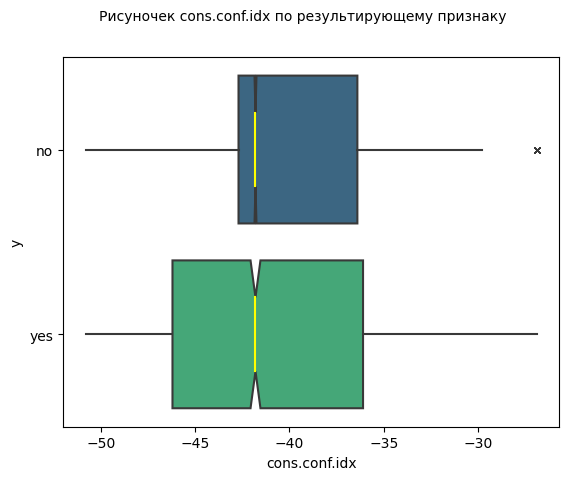

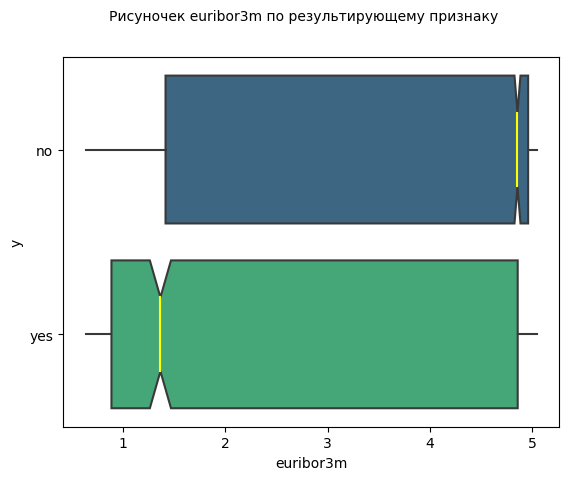

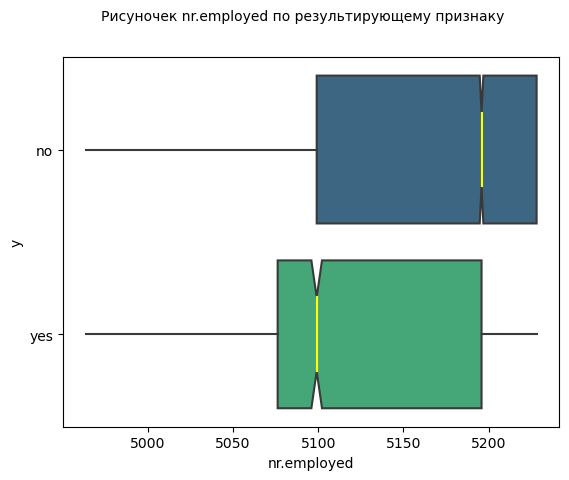

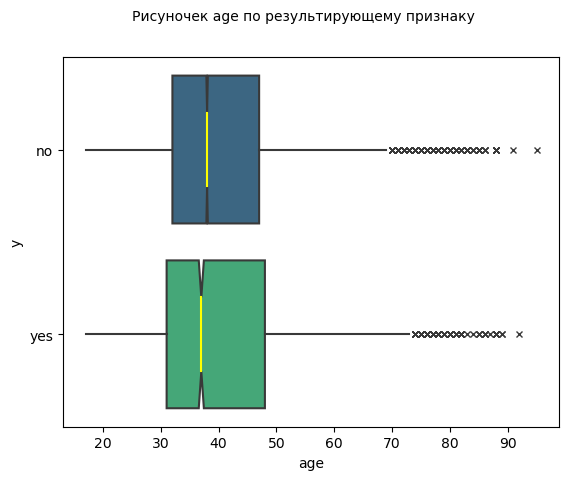

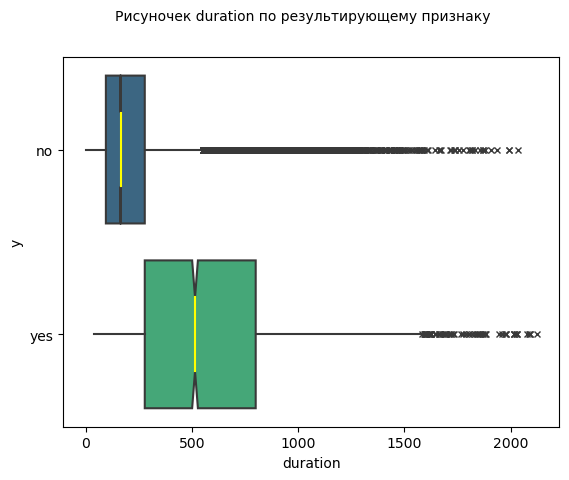

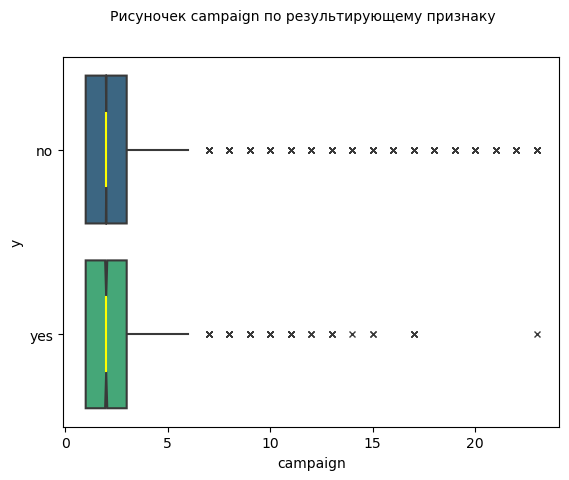

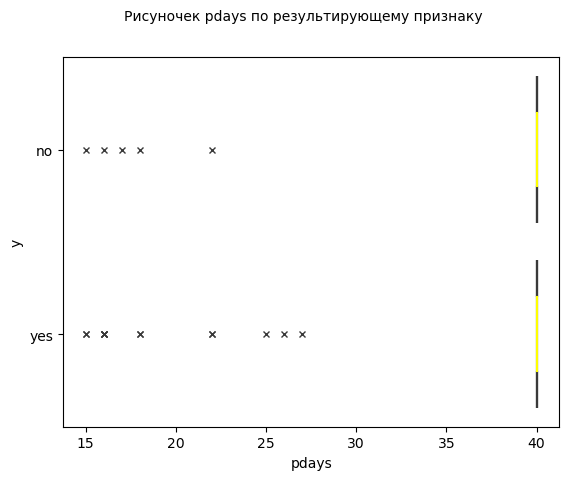

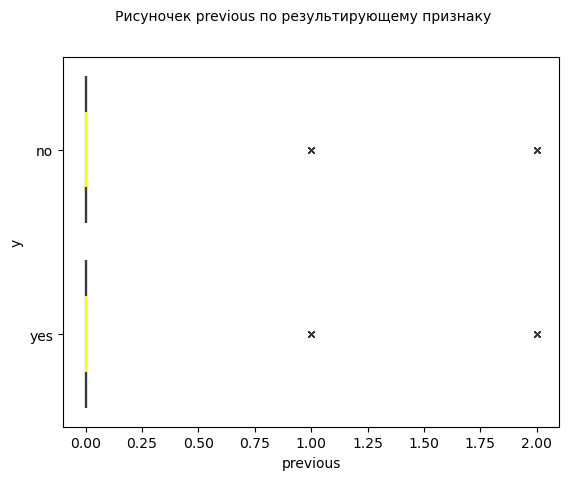

In [38]:
for c in numerical:
    cat_num_plot(c)

In [39]:
def num_plot_age(feature, rotation=90):
    f, ax = plt.subplots(1, 2, figsize=(10, 3))
    plt.suptitle(f'Рисуночек {feature} + возраст и инфа по результирующему признаку', fontsize=10)
    ax[0].tick_params(axis='x', labelrotation=30)
    ax[1].tick_params(axis='x', labelrotation=30)
    sns.scatterplot(data=df1, x=feature, y='age', hue=df1['y'], ax=ax[0], palette="viridis");
    ax = sns.histplot(ax=ax[1],x = df1[feature], hue=df1['y'], palette="viridis")
    plt.show()

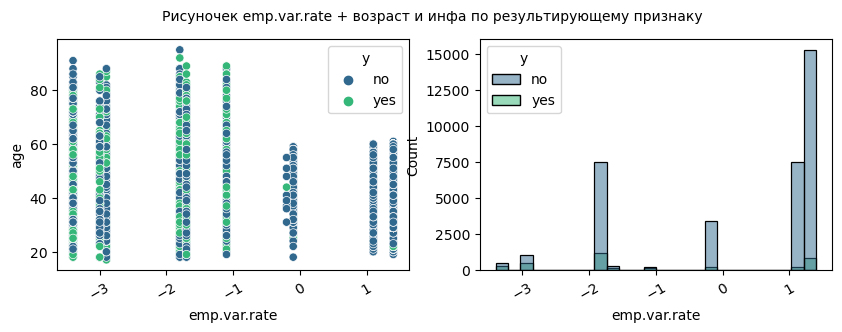

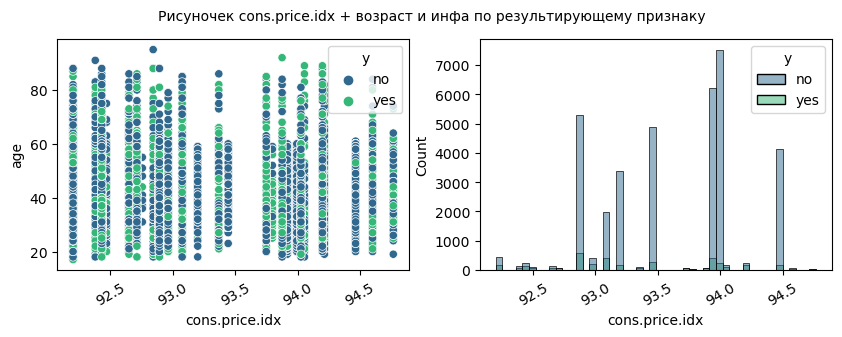

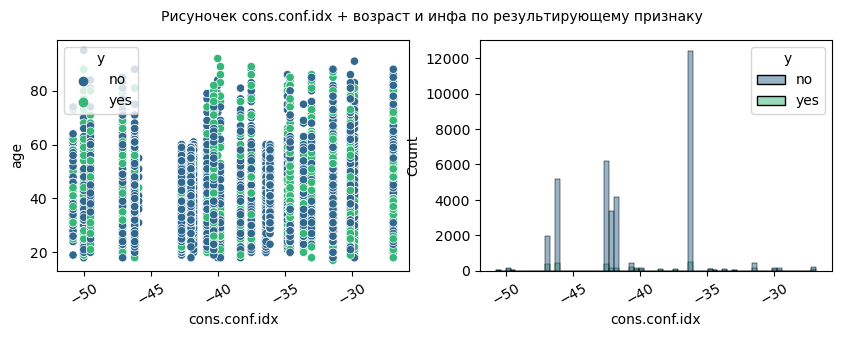

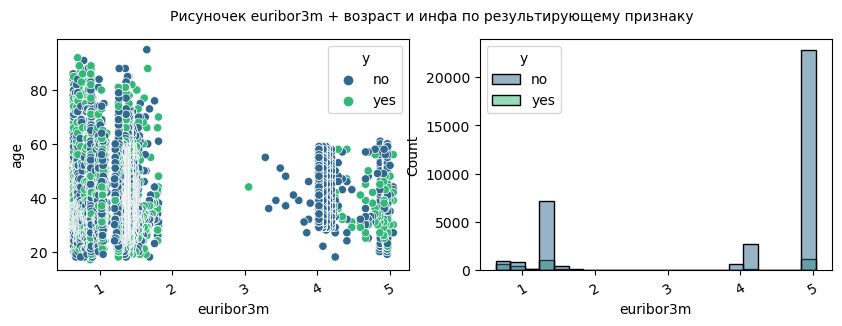

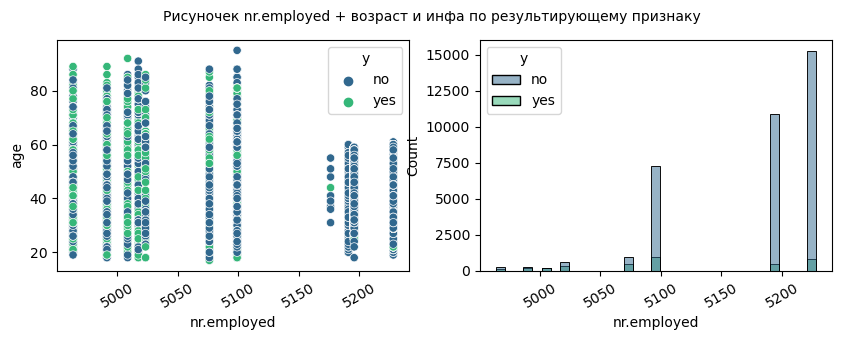

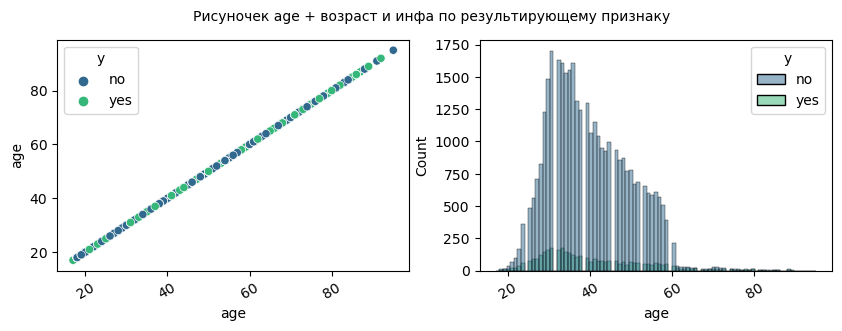

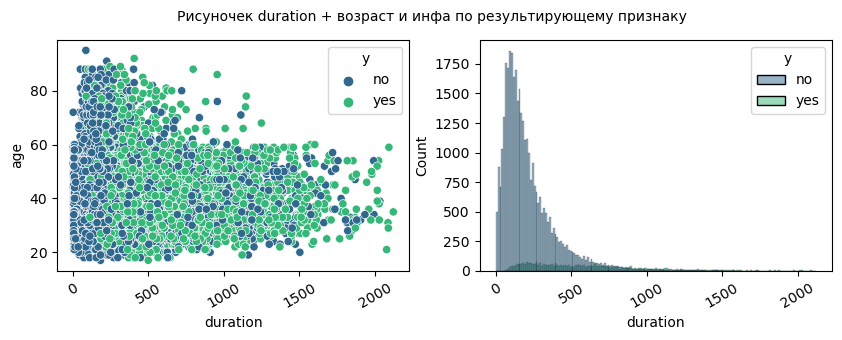

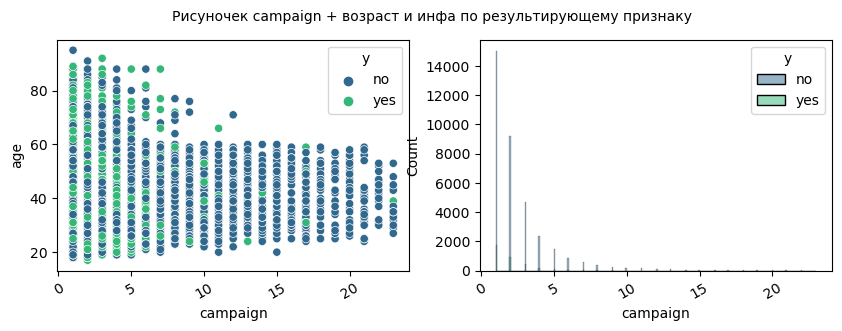

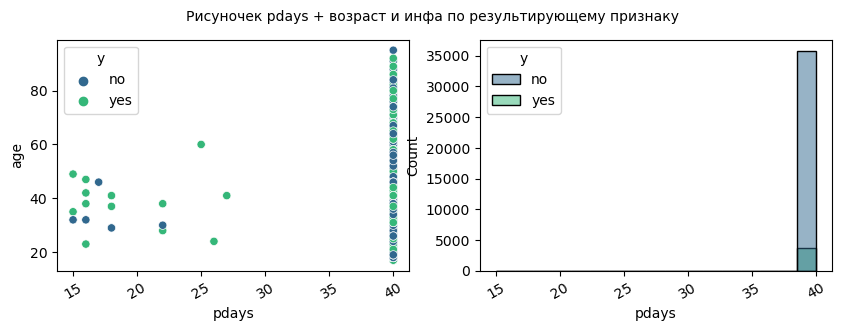

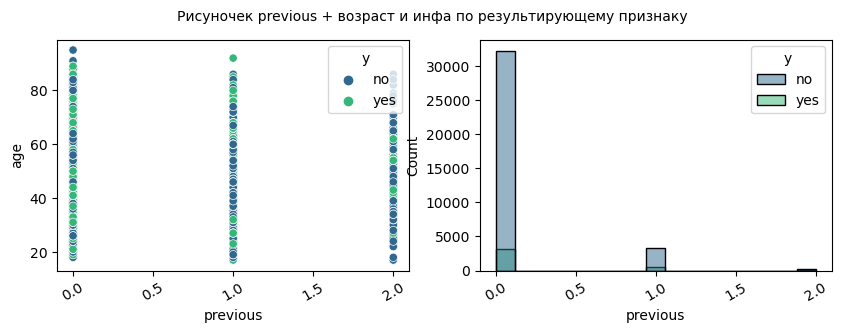

In [40]:
for c in numerical:
    num_plot_age(c)

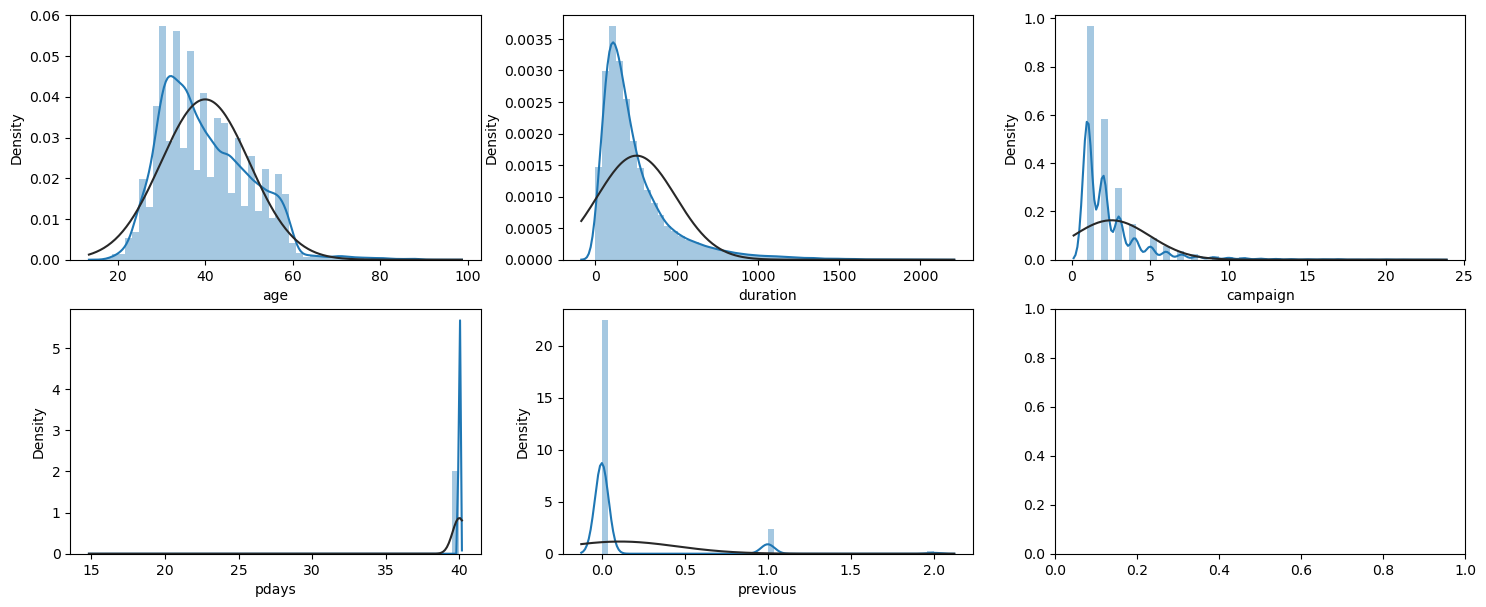

In [45]:
f, ax = plt.subplots(2, 3, figsize=(18, 7))
for i, c in enumerate(numerical_discr):
    sns.distplot(df1[c], fit=norm, ax=ax[i//3, i%3])

Вывод:

В живых остались p-days. Я достаточно постаралась, не удалила слишком много. Кампейн до 25 (раньше было до 50 с лишним), дюрейшн симпотнее (до 2к, было до 5к), сократилось превиос (было 7, стало 2)

## 4. Кодирование категориальных данных